In [403]:
import align.detect_face

In [328]:
from align.facenet import get_dataset

In [329]:
dataset = get_dataset(paths='data/CASIA-WebFace/')

# take a look of the data

In [330]:
sum(len(i.image_paths) for i in dataset)

494414

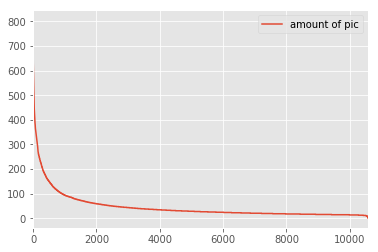

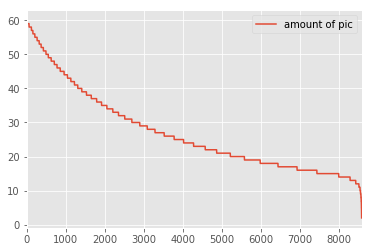

In [331]:
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('ggplot')
pd.DataFrame({'amount of pic':sorted([len(i.image_paths) for i in dataset],reverse=True)}).plot()
pd.DataFrame({'amount of pic':sorted([len(i.image_paths) for i in dataset],reverse=True)[2000:]}).plot()

In [332]:
max(len(i.image_paths) for i in dataset)

804

In [333]:
sum([int(len(i.image_paths) > 35) for i in dataset])

3913

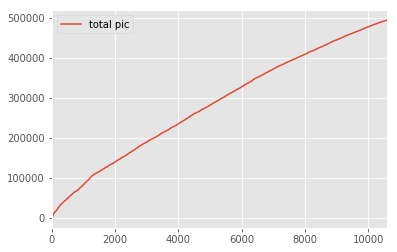

In [35]:
damount = [len(i.image_paths) for i in dataset]
for i in range(len(damount) - 1):
    damount[i + 1] += damount[i]
pd.DataFrame({'total pic':damount}).plot()

# test the image align technique

In [2]:
import align.detect_face
from scipy import misc
import tensorflow as tf
from matplotlib import pyplot as plt
plt.style.use('ggplot')

## use mtcnn

In [3]:
import align.align_dlib

In [5]:
tf.reset_default_graph()
config = tf.ConfigProto(log_device_placement=True,allow_soft_placement = True)
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [6]:
with session.as_default():
    pnet, rnet, onet = align.detect_face.create_mtcnn(session, None)

## use dlib

In [7]:
align_tool = align.align_dlib.AlignDlib('data/shape_predictor_68_face_landmarks.dat')

In [102]:
landmarkIndices = align.align_dlib.AlignDlib.OUTER_EYES_AND_NOSE

In [103]:
landmarkIndices

[36, 45, 33]

## use opencv

In [9]:
facecascade = cv2.CascadeClassifier('data/haar_cascade_frontalface_default.xml')

## define some functions

In [10]:
from align.align_dlib import TEMPLATE,MINMAX_TEMPLATE
OUTER_EYES_AND_NOSE = [36, 45, 33]
landmarkIndices = OUTER_EYES_AND_NOSE
def align_pic(left,top,right,bottom,img,scale=0.78,imgDim=110):
    left = np.long(left)
    top = np.long(top)
    right = np.long(right)
    bottom = np.long(bottom)
    bb = dlib.rectangle(left,top,right,bottom)
    landmarks = align_tool.findLandmarks(img,bb)
    npLandmarks = np.float32(landmarks)
    npLandmarkIndices = np.array(landmarkIndices)
    H = cv2.getAffineTransform(npLandmarks[npLandmarkIndices],
                               imgDim * MINMAX_TEMPLATE[npLandmarkIndices]*scale + imgDim*(1-scale)/2)
    thumbnail = cv2.warpAffine(img, H, (imgDim, imgDim))
    return thumbnail

In [11]:
def margin_pic(img,l,t,r,b,margin=44,image_size=182):
    bb = np.zeros(4, dtype=np.int32)
    avglr = int((l + r) / 2)
    avgtb = int((t + b) / 2)
    r_cir = int(max((r - l),(b - t) )/ 2)
    bb[0] = np.maximum(l-margin/2, 0)
    bb[1] = np.maximum(t-margin/2, 0)
    bb[2] = np.minimum(r+margin/2, img.shape[1])
    bb[3] = np.minimum(b+margin/2, img.shape[0])
    
    #bb[0] = np.maximum(avglr - r_cir - margin/2, 0)
    #bb[1] = np.maximum(avgtb - r_cir -margin/2, 0)
    #bb[2] = np.minimum(avglr + r_cir + margin/2, img.shape[1])
    #bb[3] = np.minimum(avgtb + r_cir + margin/2, img.shape[0])
    cropped = img[bb[1]:bb[3],bb[0]:bb[2],:]
    scaled = misc.imresize(cropped, (image_size, image_size), interp='bilinear')
    return scaled

In [12]:
def get_center_margin_ares(cord,img,margin=100,image_size=50):
    bb = np.zeros(4, dtype=np.int32)
    bb[0] = np.maximum(cord[0]-margin/2, 0)
    bb[1] = np.maximum(cord[1]-margin/2, 0)
    bb[2] = np.minimum(cord[0]+margin/2, img.shape[1])
    bb[3] = np.minimum(cord[1]+margin/2, img.shape[0])
    cropped = img[bb[1]:bb[3],bb[0]:bb[2],:]
    scaled = misc.imresize(cropped, (image_size, image_size), interp='bilinear')
    return scaled

def get_landmark_centred_pic(left,top,right,bottom,img,margin=None):
    left = np.long(left)
    top = np.long(top)
    right = np.long(right)
    bottom = np.long(bottom)
    if margin is None:
        margin = min(right - left,bottom - top) * 0.83
    bb = dlib.rectangle(left,top,right,bottom)
    landmarks = align_tool.findLandmarks(img,bb)
    npLandmarks = np.float32(landmarks)
    npLandmarkIndices = np.array(landmarkIndices)
    landmarks = npLandmarks[npLandmarkIndices]
    return map(lambda x:get_center_margin_ares(x,img,margin=margin),landmarks)
    
    

## now run all those detectors

In [389]:
sample_file = dataset[3].image_paths[2]
#sample_file = 'sample/mmexport1474478436146.jpg'
sample_img = misc.imread(sample_file)
sample_img.shape

(250, 250, 3)

In [390]:
threshold = [ 0.6, 0.7, 0.7 ]
factor = 0.709 # scale factor
bounding_boxes, _ = align.detect_face.detect_face(sample_img,250, pnet,rnet,onet,threshold,factor)

In [391]:
aligned = align_tool.align(110, sample_img, landmarkIndices=landmarkIndices,skipMulti=False)
dlib_bounders = align_tool.getAllFaceBoundingBoxes(sample_img)

In [392]:
faces = facecascade.detectMultiScale(sample_img,scaleFactor=1.1,minNeighbors=5)

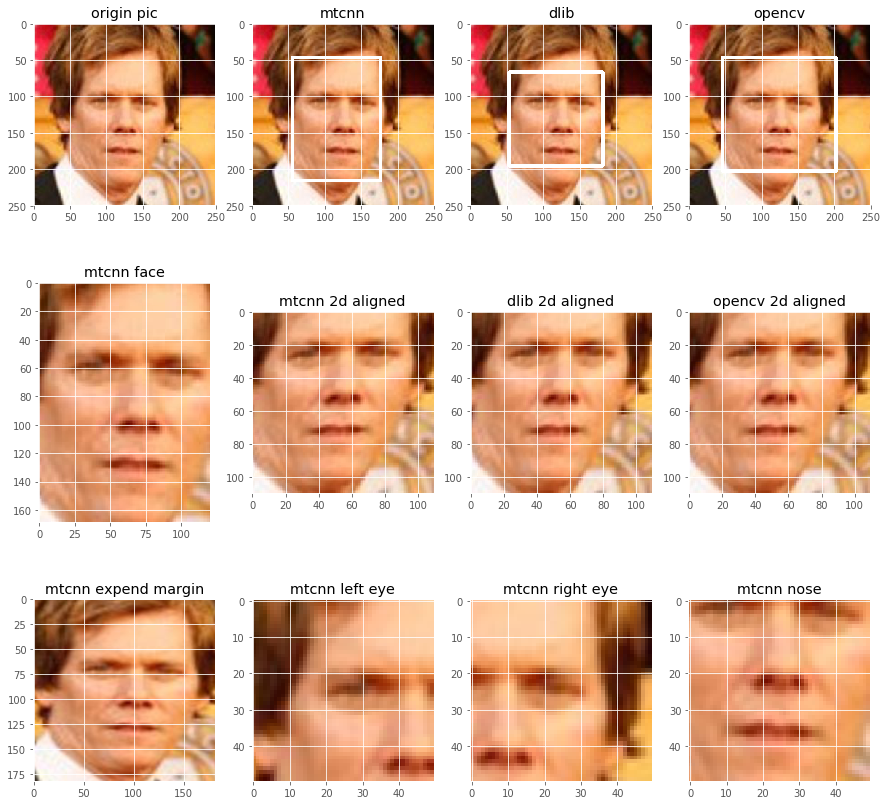

In [393]:
import cv2
import numpy as np
import dlib
plt.figure(figsize=(15,15))
img_mtnn = sample_img.copy()
img_cv2 = sample_img.copy()
img_dlib = sample_img.copy()

for i_mtnn in np.asarray(bounding_boxes,dtype=np.int):
    img_mtnn = cv2.rectangle(img_mtnn,(i_mtnn[0],i_mtnn[1]),(i_mtnn[2],i_mtnn[3]),(255,255,255),4)
for i_dlib in dlib_bounders:
    img_dlib = cv2.rectangle(img_dlib,(i_dlib.left(),i_dlib.top()),(i_dlib.right(),i_dlib.bottom()),(255,255,255),4)
for i_cv2 in np.asarray(faces,dtype=np.int):
    img_cv2 = cv2.rectangle(img_cv2,(i_cv2[0],i_cv2[1]),(i_cv2[0] + i_cv2[2],i_cv2[1] + i_cv2[3]),(255,255,255),4)
    
    
plt.subplot(3,4,1)
plt.imshow(sample_img)
plt.title('origin pic')
plt.subplot(3,4,2)
if bounding_boxes is not None:
    plt.imshow(img_mtnn)
    plt.title('mtcnn')
plt.subplot(3,4,3)
if dlib_bounders is not None:
    plt.imshow(img_dlib)
    plt.title('dlib')
plt.subplot(3,4,4)
if len(faces) > 0:
    plt.imshow(img_cv2)
    plt.title('opencv')


plt.subplot(3,4,5)
if len(bounding_boxes) > 0:
    plt.imshow(sample_img[i_mtnn[1]:i_mtnn[3],i_mtnn[0]:i_mtnn[2]])
    plt.title('mtcnn face')
plt.subplot(3,4,6)
if len(bounding_boxes) > 0:
    plt.imshow(align_pic(i_mtnn[0],i_mtnn[1],i_mtnn[2],i_mtnn[3],sample_img))
    plt.title('mtcnn 2d aligned')
else:
    plt.imshow(align_pic(0,0,sample_img.shape[0],sample_img.shape[1],sample_img))
    plt.title('mtcnn 2d aligned using full pic')
plt.subplot(3,4,7)
if len(dlib_bounders) > 0:
    plt.imshow(align_pic(i_dlib.left(),i_dlib.top(),i_dlib.right(),i_dlib.bottom(),sample_img))
    plt.title('dlib 2d aligned')
plt.subplot(3,4,8)
if len(faces) > 0:
    plt.imshow(align_pic(
        i_cv2[0],i_cv2[1],i_cv2[0] + i_cv2[2],i_cv2[1] + i_cv2[3],sample_img))
    plt.title('opencv 2d aligned')

    
plt.subplot(3,4,9)
if len(bounding_boxes) > 0:
    plt.imshow(margin_pic(sample_img,i_mtnn[0],i_mtnn[1],i_mtnn[2],i_mtnn[3]))
    plt.title('mtcnn expend margin')
    
if len(bounding_boxes) > 0:
    centpic1,centpic2,centpic3 = get_landmark_centred_pic(i_mtnn[0],i_mtnn[1],i_mtnn[2],i_mtnn[3],sample_img)
    #centpic1,centpic2,centpic3 = get_landmark_centred_pic(0,0,sample_img.shape[1],sample_img.shape[0],sample_img)
    plt.subplot(3,4,10);plt.imshow(centpic1);plt.title('mtcnn left eye')
    plt.subplot(3,4,11);plt.imshow(centpic2);plt.title('mtcnn right eye')
    plt.subplot(3,4,12);plt.imshow(centpic3);plt.title('mtcnn nose')

In [40]:
ls data/

CASIA-WebFace/                        shape_predictor_68_face_landmarks.dat
haar_cascade_frontalface_default.xml


# test cases

In [444]:
import imp
imp.reload(align.boxing)
from align.boxing import *

In [424]:
tf.reset_default_graph()
mtbox = CascadeBoxing()

In [425]:
mtbox.get_facebox(img=sample_img)

(55.957020118832588,
 47.699832156300545,
 176.63576440513134,
 216.52198016643524)

In [402]:
dlbox = DlibBoxing()

In [403]:
dlbox.get_facebox(img=sample_img)

(53, 67, 182, 196)

In [404]:
cvbox = ()

In [405]:
cvbox.get_facebox(img=sample_img)

(47, 47, 203, 203)

In [445]:
tf.reset_default_graph()
cabox = CenterBlindBoxing()


In [446]:
cabox.get_facebox(sample_img)

(62.5, 62.5, 187.5, 187.5)

In [408]:
imp.reload(align.landmarks)
from align.landmarks import *

In [409]:
lp = DlibLandmarkPredictor()

In [413]:
imp.reload(align.segment)
from align.segment import *

In [414]:
ts = TwodAlignSegmenter(scale=0.78)

In [415]:
cabox.get_facebox(sample_img)

(55.957020118832588,
 47.699832156300545,
 176.63576440513134,
 216.52198016643524)

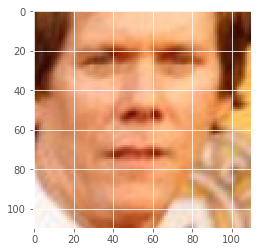

In [447]:
fb = cabox.get_facebox(sample_img)
plt.imshow(
    ts.segment(sample_img,box=fb,landmarks=lp.get_landmarks(sample_img,box=fb),)[0][1]
    )

In [417]:
es = ExpandMarginSegmenter(margin=0.5)
#fb = [0,0,250,250]

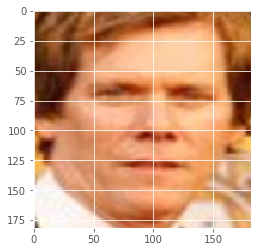

In [418]:
plt.imshow(
    es.segment(sample_img,box=fb,landmarks=lp.get_landmarks(sample_img,box=fb),)[0][1]
    )

In [419]:
fs = CascadeSegmenter(prefix='cs')

In [420]:
res = fs.segment(sample_img,box=fb,landmarks=lp.get_landmarks(sample_img,box=fb))

(110, 110, 3)
(182, 182, 3)
(50, 50, 3)
(50, 50, 3)
(50, 50, 3)


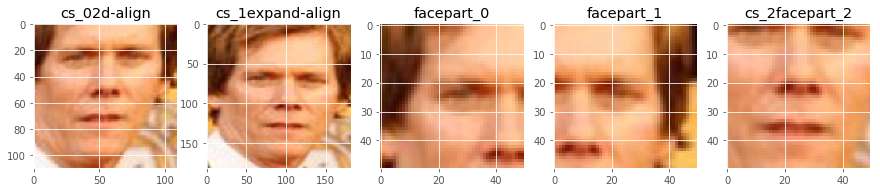

In [421]:
%matplotlib inline
plt.figure(figsize=(15,15))
for i,one in enumerate(res):
    name,pic = one
    print(pic.shape)
    plt.subplot(1,5,i + 1)
    plt.imshow(pic)
    plt.title(name)

In [388]:
dataset[0].image_paths,dataset[0].name

(['data/CASIA-WebFace/0000045/005.jpg',
  'data/CASIA-WebFace/0000045/001.jpg',
  'data/CASIA-WebFace/0000045/010.jpg',
  'data/CASIA-WebFace/0000045/002.jpg',
  'data/CASIA-WebFace/0000045/015.jpg',
  'data/CASIA-WebFace/0000045/014.jpg',
  'data/CASIA-WebFace/0000045/006.jpg',
  'data/CASIA-WebFace/0000045/004.jpg',
  'data/CASIA-WebFace/0000045/011.jpg',
  'data/CASIA-WebFace/0000045/003.jpg',
  'data/CASIA-WebFace/0000045/013.jpg',
  'data/CASIA-WebFace/0000045/012.jpg',
  'data/CASIA-WebFace/0000045/008.jpg',
  'data/CASIA-WebFace/0000045/009.jpg',
  'data/CASIA-WebFace/0000045/007.jpg'],
 '0000045')

In [426]:
sample_file

'data/CASIA-WebFace/0000102/223.jpg'

In [428]:
ll data/CAS_aled_cs_1expand-align/0000102/ | head

total 2964
-rw-rw-r-- 1 mtq 4214 Jul  3 14:40 001.jpg
-rw-rw-r-- 1 mtq 3639 Jul  3 14:40 002.jpg
-rw-rw-r-- 1 mtq 5234 Jul  3 14:40 003.jpg
-rw-rw-r-- 1 mtq 5777 Jul  3 14:40 004.jpg
-rw-rw-r-- 1 mtq 4258 Jul  3 14:40 005.jpg
-rw-rw-r-- 1 mtq 3199 Jul  3 14:40 006.jpg
-rw-rw-r-- 1 mtq 6017 Jul  3 14:40 007.jpg
-rw-rw-r-- 1 mtq 3301 Jul  3 14:40 008.jpg
-rw-rw-r-- 1 mtq 4735 Jul  3 14:40 009.jpg
ls: write error


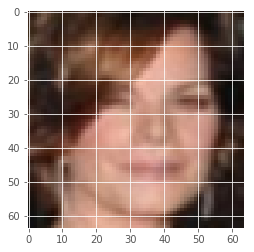

In [70]:
from matplotlib import pyplot as plt
from scipy import misc
%matplotlib inline
plt.style.use('ggplot')
plt.imshow(
    misc.imresize(
    misc.imread( 'data/CAS_aled_cs_1expand-align/0001315/013.jpg')
        ,(64,64))
          )

# generate label file

In [468]:
dataset = get_dataset('data/CAS_aled_cs_1expand-align/')

In [470]:
len(dataset)

10575

In [486]:
dset_part_sorfmax = [i for i in dataset if len(i) > 20]

In [487]:
len(dset_part_sorfmax)

7211

In [502]:
labels = []
files = []
act_dirs = []
for num_ind,i in enumerate(dset_part_sorfmax):
    files += i.image_paths
    labels += [num_ind] * len(i.image_paths)
    act_dirs += [i] * len(i.image_paths)

In [503]:
len(labels),len(files)

(438912, 438912)

In [526]:
from sklearn.cross_validation import train_test_split
train_labels,test_labels,train_files,test_files = train_test_split(labels,files,test_size=0.1,random_state=0)

In [525]:
?train_test_split

In [505]:
len(train_labels),len(test_labels)

(395020, 43892)

In [508]:
with open('data/textlabel/train_align.txt','w') as whdl:
    for f,l in zip(train_files,train_labels):
        whdl.write("{} {}\n".format(f,l))
with open('data/textlabel/test_align.txt','w') as whdl:
    for f,l in zip(test_files,test_labels):
        whdl.write("{} {}\n".format(f,l))

In [513]:
!wc -l data/textlabel/*

   43892 data/textlabel/test_align.txt
  395020 data/textlabel/train_align.txt
  438912 total


In [514]:
from tflearn.data_utils import image_preloader

In [516]:
misc.imread( 'data/CAS_aled_cs_1expand-align/0001315/014.jpg').shape

(182, 182, 3)

In [522]:
train_x,train_y = image_preloader('data/textlabel/train_align.txt',(182,182))
test_x,test_y = image_preloader('data/textlabel/test_align.txt',(182,182))

In [535]:
test_y[0].shape

(7211,)

In [528]:
from tflearn.layers import *
from tflearn.models import *
import tflearn

In [ ]:
net = tflearn.input_data(shape=[None, 32, 32, 3])
net = tflearn.conv_2d(64,)

In [543]:
?tflearn.layers.conv_2d

In [542]:
?tflearn.max_pool_2d

In [532]:
?tflearn.residual_block

In [533]:
?tflearn.global_avg_pool

In [534]:
?tflearn.fully_connected

In [539]:
?tflearn.DNN

In [346]:
import tflearn 
import tensorflow as tf
from tflearn.data_utils import image_preloader

INPUT_DATADIR = 'data/CAS_aled_cs_1expand-align/'
DATA_MORETHAN = 20
TEST_SIZE = 0.1
creat_dirs = ['data/textlabel/','models']
TRAIN_TXT = 'data/textlabel/train_align.txt'
TEST_TXT = 'data/textlabel/test_align.txt'
ID_DIR_TXT = 'data/textlabel/id_dir_align.txt'
MODEL_FILE = 'expend_align_face'
RUN_ID = MODEL_FILE
IMG_SIZE = 182

train_x,train_y = image_preloader(TRAIN_TXT,(IMG_SIZE,IMG_SIZE))
test_x,test_y = image_preloader(TEST_TXT,(IMG_SIZE,IMG_SIZE))

tf.reset_default_graph()
config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

In [347]:
tflearn.config.init_training_mode()
with tf.device("/gpu:1"):
	net = tflearn.input_data(shape=[None,64,64,3])
	net = tflearn.conv_2d(net,64,7,2)
	# [91,91,64]
	net = tflearn.max_pool_2d(net,3,2)
	# [46,46,64]
	net = tflearn.residual_block(net,2,64)
	# [46,46,64]
	net = tflearn.residual_block(net,1,128,downsample=True)
	# [23,23,128]
	net = tflearn.residual_block(net,1,128)
	# [23,23,128]
	net = tflearn.residual_block(net,1,256,downsample=True)
	# [12,12,256]
	net = tflearn.residual_block(net,1,256)
	# [12,12,256]
	net = tflearn.residual_block(net,1,512,downsample=True)
	# [6,6,512]
	net = tflearn.residual_block(net,1,512)
	# [6,6,512]
	net = tflearn.global_avg_pool(net)
	# [512]
	fully_connect = tflearn.fully_connected(net,160,activation='relu')
	# [1000]
	net = tflearn.fully_connected(fully_connect,3913)
	# [7211]
	mom = tflearn.Momentum(0.01,lr_decay=0.1,decay_step=3086 * 20)
	reg = tflearn.regression(net,optimizer=mom,loss='categorical_crossentropy')
	model = tflearn.DNN(reg,checkpoint_path='models/{}'.format(MODEL_FILE),max_checkpoints=100,session=sess)

In [348]:
saver = tf.train.Saver()
#sess.run(tf.global_variables_initializer())

In [349]:
saver.restore(sess,'models/resnet34net_64size_160hidden_35class-78840')
#model.load('models/expend_align_face-30870',weights_only=True)

In [60]:
?tflearn.SGD

# lfw

In [404]:
ls lfw/lfw_6000_pair/ | head

0000_0.jpg
0000_1.jpg
0001_0.jpg
0001_1.jpg
0002_0.jpg
0002_1.jpg
0003_0.jpg
0003_1.jpg
0004_0.jpg
0004_1.jpg
ls: write error


In [405]:
import os
prefix = 'lfw/lfw_6000_pair/'
lfw_files = os.listdir(prefix)

In [406]:
lfw_files = sorted(lfw_files)

In [407]:
import matplotlib.image as mpimg
lfw_labels = [1 - i // 300  % 2 for i in range(6000)]

In [408]:
len(lfw_labels),len(lfw_files)

(6000, 12000)

In [355]:
from align.boxing import *
cascade_box = CascadeBoxing()
center_box = CenterBlindBoxing()

In [356]:
from align.landmarks import DlibLandmarkPredictor
from align.segment import CascadeSegmenter
landmark_predictor = DlibLandmarkPredictor()
cascade_segmenter = CascadeSegmenter(prefix='cs')

In [357]:
from utils import *

In [409]:
import tensorflow as tf
import tflearn
tf.reset_default_graph()
config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
IMG_SIZE = 224
GPU_CORE = 5
HIDDEN = 160
BATCH_SIZE = 64
tflearn.config.init_training_mode()
with tf.device("/gpu:{}".format(GPU_CORE)):
    indat = tflearn.input_data(shape=[None,224,224,3])
    net = tflearn.conv_2d(indat,64,7,2, regularizer='L2', weight_decay=0.0001)
    # [91,91,64]
    net = tflearn.max_pool_2d(net,3,2)
    # [46,46,64]
    net = tflearn.residual_block(net,3,64)
    # [46,46,64]
    net = tflearn.residual_block(net,1,128,downsample=True)
    # [23,23,128]
    net = tflearn.residual_block(net,3,128)
    # [23,23,128]
    net = tflearn.residual_block(net,1,256,downsample=True)
    # [12,12,256]
    net = tflearn.residual_block(net,5,256)
    # [12,12,256]
    net = tflearn.residual_block(net,1,512,downsample=True)
    # [6,6,512]
    net = tflearn.residual_block(net,2,512)
    # [6,6,512]
    net = tflearn.global_avg_pool(net)
    # [512]
    fully_connect = tflearn.fully_connected(net,HIDDEN,activation='relu')
    # [1000]
    net = tflearn.fully_connected(fully_connect,7211,activation='softmax')
    # [7211]
    #mom = tflearn.SGD(0.1,lr_decay=0.1,decay_step=3086 * 20)
    mom = tflearn.Momentum(0.01,lr_decay=0.1,decay_step=int(395000 / BATCH_SIZE) * 10)
    reg = tflearn.regression(net,optimizer=mom,loss='categorical_crossentropy')
    model = tflearn.DNN(reg,checkpoint_path='models/{}'.format(MODEL_FILE),max_checkpoints=100,session=sess)

In [415]:
import tensorflow as tf
import tflearn
tf.reset_default_graph()
config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
IMG_SIZE = 224
GPU_CORE = 5
HIDDEN = 160
BATCH_SIZE = 64
tflearn.config.init_training_mode()
with tf.device("/gpu:{}".format(GPU_CORE)):
    input_layer = tflearn.input_data([None, IMG_SIZE, IMG_SIZE, 3])
    net = tflearn.conv_2d(input_layer, 64, 7, strides=2)
    net = tflearn.max_pool_2d(net, 3, strides=2)
    net = tflearn.residual_block(net, 3, 64)
    net = tflearn.residual_block(net, 1, 128, downsample=True)
    net = tflearn.residual_block(net, 3, 128)
    net = tflearn.residual_block(net, 1, 256, downsample=True)
    net = tflearn.residual_block(net, 5, 256)
    net = tflearn.residual_block(net, 1, 512, downsample=True)
    net = tflearn.residual_block(net, 2, 512)
    net = tflearn.global_avg_pool(net)
    fully_connected = tflearn.fully_connected(net, HIDDEN, activation="relu")
    result = tflearn.fully_connected(fully_connected, 7211, activation='softmax')
    mom = tflearn.Momentum(0.01, lr_decay=0.1, decay_step=int(395000 / BATCH_SIZE) * 300098, staircase=True)
    net = tflearn.regression(result, optimizer=mom, loss="categorical_crossentropy")
    model = tflearn.DNN(net,checkpoint_path='models/{}'.format(MODEL_FILE),session=sess,max_checkpoints=100,
                            tensorboard_verbose=0)

In [416]:
sess.run(tf.global_variables_initializer())

In [417]:
saver = tf.train.Saver()

In [418]:
saver.restore(sess,'models/res-cp_224_160-135795')

In [441]:
ll models/res-cp_224_160-135795*

-rw-rw-r-- 1 mtq 178940917 Jul  8 20:31 models/res-cp_224_160-135795.data-00000-of-00001
-rw-rw-r-- 1 mtq     14452 Jul  8 20:31 models/res-cp_224_160-135795.index
-rw-rw-r-- 1 mtq   5056062 Jul  8 20:31 models/res-cp_224_160-135795.meta


In [424]:
TEST_TXT = 'data/textlabel/test_align.txt'
test_x,test_y = image_preloader(TEST_TXT,(IMG_SIZE,IMG_SIZE))

In [425]:
from scipy import misc

pb = ProgressBar(worksum=len(test_y),info="processing...")
pb.startjob()
total_num = 0
correct_num = 0
for one_x,result in zip(test_x,test_y):
    predicted = np.argmax(model.predict([one_x])[0])
    actual = np.argmax(result)
    if predicted == actual:
        correct_num += 1
    total_num += 1
    percent = 100 * float(correct_num) / total_num
    percent = round(percent)
    pb.info = "processing, acc : {} % ".format(percent)
    pb.complete(1)

In [426]:
import numpy as np
np.argmax(model.predict([test_x[0]])[0])

4797

In [427]:
np.argmax(test_y[0])

4797

In [428]:
from align.segment import ExpandMarginSegmenter

In [393]:
??ExpandMarginSegmenter

In [394]:
es = ExpandMarginSegmenter()

In [432]:

pb = ProgressBar(worksum=len(lfw_files),info="processing...")
pb.startjob()
seg_list = []
lfw_pairs = []
for i,j in zip(lfw_files[::2],lfw_files[1::2]):
    one_pair = []
    for one_img in [i,j]:
        one_img = misc.imread('lfw/lfw_6000_pair_ori/' + one_img)
        box = cascade_box.get_facebox(one_img)
        if box is None:
            box = center_box.get_facebox(one_img)
        landmarks = landmark_predictor.get_landmarks(one_img,box=box)
        segmented = es.segment(one_img,box=box,landmarks=landmarks)[0][1]
        segmented = misc.imresize(segmented,(224,224))
        segmented = segmented / 255
        seg_list.append(segmented)
        hidden_vector = sess.run(fully_connected,feed_dict={input_layer:[segmented]})[0]
        one_pair.append(hidden_vector)
        pb.complete(1)
    lfw_pairs.append(one_pair)

processing... 100.00 % [==================================================>] 12000/12000 	 used:1316s eta:0 s

In [433]:
lfw_pairs[0][0].shape

(160,)

In [434]:
import numpy as np
import scipy
scores = [1-  scipy.spatial.distance.cosine(x,y) for x,y in lfw_pairs]

In [435]:
#scores = [np.sum(em1 * em2) / np.sqrt(np.sum(np.square(em1)) * np.sum(np.square(em2))) for em1,em2 in lfw_pairs]

In [436]:
from sklearn.metrics import roc_auc_score

In [437]:
print(roc_auc_score(lfw_labels,scores))

0.984600444444


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0b36d7e2e8>]], dtype=object)

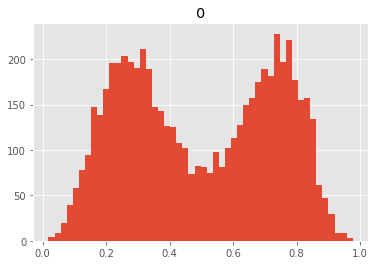

In [438]:
import pandas as pd
pd.DataFrame(scores).hist(bins=50)

In [445]:
np.mean(np.asarray(lfw_labels) == np.asarray(np.asarray(scores) > 0.5))

0.94999999999999996

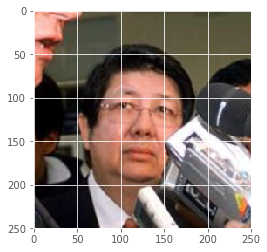

In [310]:
plt.imshow(one_img)

In [282]:
len(lfw_pairs[0][0])

160

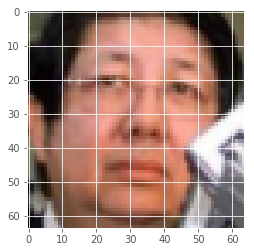

In [281]:
plt.imshow(segmented)

In [446]:
?tflearn.conv_2d